In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **IMPORTING NLTK**

In [2]:
import nltk
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------

Download which package (l=list; x=cancel)?
       | 
       | Downloading package abc to /root/nltk_data...
       |   Unzipping corpora/abc.zip.
       | Downloading package alpino to /root/nltk_data...
       |   Unzipping corpora/alpino.zip.
       | Downloading package averaged_perceptron_tagger to
       |     /root/nltk_data...
       |   Unzipping taggers/averaged_perceptron_tagger.zip.
       | Downloading package averaged_perceptron_tagger_ru to
       |     /root/nltk_data...
       |   Unzipping taggers/averaged_perceptron_tagger_ru.zip.
       | Downloading package basque_grammars to /root/nltk_data...
       |   Unzipping grammars/basque_grammars.zip.
       | Downloading package biocreative_ppi to /root/nltk_data...
       |   Unzipping

True

## **IMPORTING DATA**

In [3]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
df = pd.read_csv('/content/drive/MyDrive/Omdena/Hyderabad Chapter - Chatbot for Admitted patients/Predictions_with_class.csv')
df.head()

,tweetsORG,cleanTweets,Class,Annotation
0,Elden Ring's equivalent of elves are faerie-li...,Elden Ring's equivalent of elves are faerie-li...,Common Procedures,0
1,I hate men who dress well bc they have the mos...,I hate men who dress well bc they have the mos...,Common Procedures,0
2,@princexcalamity That is so cool! Congrats!!!,That is so cool! Congrats!!!,Common Procedures,0
3,"@GRomePow You won't hear it from me at $0.00, ...","You won't hear it from me at $0.00, I was trad...",Common Procedures,0
4,The G Virus has an alluring purple color. Curi...,The G Virus has an alluring purple color. Curi...,Common Procedures,1


In [8]:
# 1=relevant and 0=irrelevant
df['Annotation'].value_counts()

0    39272
1    23001
Name: Annotation, dtype: int64

In [14]:
df_relevant = df[df['Annotation'] == 1]
df_relevant['Annotation'].value_counts()

1    23001
Name: Annotation, dtype: int64

In [9]:
df['Class'].value_counts()

Treatment            7023
Emergency Care       6792
Common Procedures    6788
Medical Facility     6372
Hospital Staff        615
Name: Class, dtype: int64

In [10]:
df['Class'].isna().sum()

34683

In [11]:
df.columns

Index(['tweetsORG', 'cleanTweets', 'Class', 'Annotation'], dtype='object')

In [15]:
data = df_relevant[['tweetsORG', 'Class']]
data.head()

,tweetsORG,Class
4,The G Virus has an alluring purple color. Curi...,Common Procedures
23,"cat had to have second surgery on top of spay,...",Common Procedures
26,My blood type is B negative. I should donate s...,Common Procedures
27,"I don't like blood clots or water poisoning, I...",Common Procedures
31,There is no IV contrast for radiological scans...,Common Procedures


In [16]:
data.shape

(23001, 2)

In [17]:
data['Class'].isna().sum()

8109

## **TWEETS WORD COUNT**

In [18]:
data['Word count'] = [len(i) for i in data.tweetsORG]
data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,tweetsORG,Class,Word count
4,The G Virus has an alluring purple color. Curi...,Common Procedures,303
23,"cat had to have second surgery on top of spay,...",Common Procedures,236
26,My blood type is B negative. I should donate s...,Common Procedures,59
27,"I don't like blood clots or water poisoning, I...",Common Procedures,60
31,There is no IV contrast for radiological scans...,Common Procedures,133


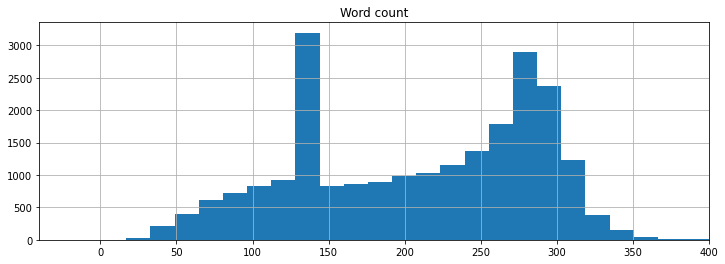

In [19]:
data.hist(column='Word count',bins=60,figsize=(12,4));
plt.xlim(-40,400);

## **VADER SENTIMENT ANALYSIS**

In [20]:
!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 13.9 MB/s 


In [21]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [22]:
def sentiment(scores):
  del scores['compound']
  maxi = max(zip(scores.values(), scores.keys()))[1]
  if maxi == 'pos' : return "Positive" 
  elif maxi == 'neg' : return "Negative"
  elif maxi == 'neu'  : return "Neutral"

def vader(doc, col):
  analyzer = SentimentIntensityAnalyzer()
  doc['Sentiment'] = doc[col].apply(lambda x: sentiment(analyzer.polarity_scores(x)))
  return doc

In [23]:
data_sen = vader(data, 'tweetsORG')

In [24]:
data_sen.Sentiment.value_counts()

Neutral     22787
Positive      146
Negative       68
Name: Sentiment, dtype: int64

Text(0.5, 1.0, 'Sentiment value Counts')

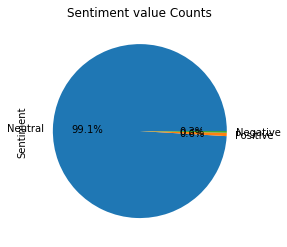

In [25]:
data_sen['Sentiment'].value_counts().plot.pie(autopct ='%1.1f%%').set_title('Sentiment value Counts')

## **PREPROCESSING TWEETS**

In [26]:
import gensim
import re
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer, LancasterStemmer
from nltk.stem.porter import *
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from string import punctuation
np.random.seed(2018)

In [27]:
stemmer = SnowballStemmer('english')

In [28]:
def word_lemmatizer(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

In [29]:
def preprocess(doc, col):
    doc['Preprocessed_Data'] = doc[col].str.replace('\n',' ')
    doc['Preprocessed_Data'] = doc['Preprocessed_Data'].apply(lambda x : re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\)]|'\
                                                                              '(?:%[0-9a-fA-F][0-9a-fA-F]))+','',x))
    doc['Preprocessed_Data'] = doc['Preprocessed_Data'].apply(lambda x :  ' '.join(word_lemmatizer(tok) for tok in gensim.utils.simple_preprocess(x) if tok not in gensim.parsing.preprocessing.STOPWORDS if len(tok) > 3 and tok not in punctuation and tok.lower() not in gensim.parsing.preprocessing.STOPWORDS))             
    return doc

In [30]:
data_pre = preprocess(data_sen, 'tweetsORG')
data_pre.sample(5)

,tweetsORG,Class,Word count,Sentiment,Preprocessed_Data
55528,@DocVitriol @Jim_Jordan @Alexand18711 I expect...,NaN,65,Neutral,docvitriol jim_jordan alexand expect doctor
36457,@3Dumbfirstnames @_pincheAP @TWLadyGrey @sansc...,NaN,749,Neutral,dumbfirstnam twladygrey sansculottestoo velma_...
8564,Our Urgent Care location will be closed today ...,Emergency Care,272,Neutral,urgent care locat close today weather staff st...
12759,"@FrozenAlchemy My mom died, years ago, in an I...",Emergency Care,270,Neutral,frozenalchemi die year curious talk triag care...
14429,You will remember that the current St Vincent'...,Medical Facility,280,Neutral,rememb current vincent hospit say right svhg p...


In [31]:
pos = list( data_pre.Preprocessed_Data[data_pre['Sentiment'] == 'Positive'] )
pos_clean = [[j for j in pos[i].split(' ')] for i in range(len(pos)) ]

neg = list( data_pre.Preprocessed_Data[data_pre['Sentiment'] == 'Negative'] )
neg_clean = [[j for j in neg[i].split(' ')] for i in range(len(neg)) ]

neu = list( data_pre.Preprocessed_Data[data_pre['Sentiment'] == 'Neutral'] )
neu_clean = [[j for j in neu[i].split(' ')] for i in range(len(neu)) ]

## **WORD CLOUDS**

In [32]:
from wordcloud import WordCloud, STOPWORDS

In [33]:
'''Plots wordcloud for any list of data'''

def Word_Cloud(df, cloud_title):
    comment_words = ""
    stopwords = set(STOPWORDS)
    
    for val in df:
        comment_words += " ".join(val)+" "

    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='black',
                    stopwords = stopwords,
                    min_font_size = 10).generate(comment_words)

    plt.figure(figsize = (4,4), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(cloud_title)
    plt.show()

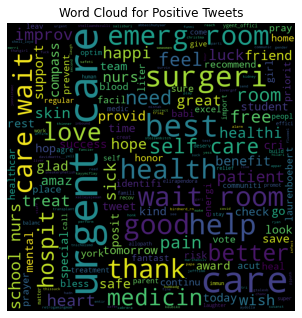

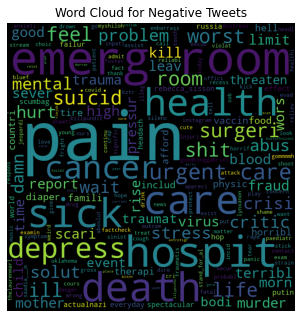

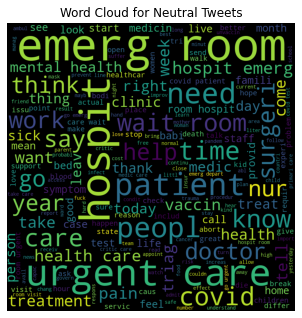

In [34]:
Word_Cloud(pos_clean, 'Word Cloud for Positive Tweets')
Word_Cloud(neg_clean, 'Word Cloud for Negative Tweets')
Word_Cloud(neu_clean, 'Word Cloud for Neutral Tweets')

## **TOP 30 WORDS**

In [35]:
from collections import Counter

In [36]:
pos_list = [item for i in pos_clean for item in i]
neg_list = [item for i in neg_clean for item in i]
neu_list = [item for i in neu_clean for item in i]

In [37]:
len(pos_list), len(neg_list), len(neu_list)

(1098, 489, 353459)

In [38]:
c_positive = Counter(pos_list)
c_negative  = Counter(neg_list)
c_neutral  = Counter(neu_list)

top30_positive = pd.DataFrame(c_positive.most_common(30), columns=['word', 'count'])
top30_negative = pd.DataFrame(c_negative.most_common(30),  columns=['word', 'count'])
top30_neutral = pd.DataFrame(c_neutral.most_common(30),  columns=['word', 'count'])

#### **Positive**

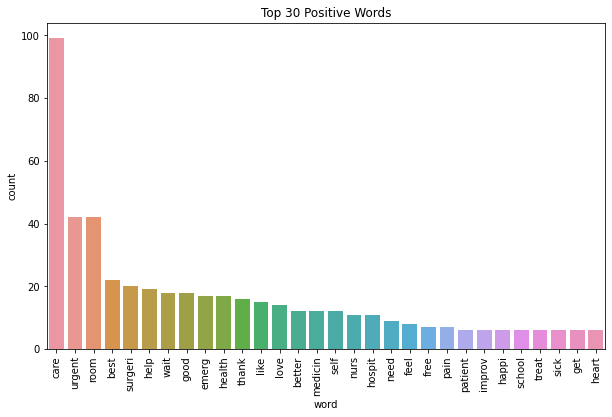

In [39]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='word', y='count', 
            data=top30_positive, ax=ax)
plt.title("Top 30 Positive Words")
plt.xticks(rotation='vertical');

#### **Negative**

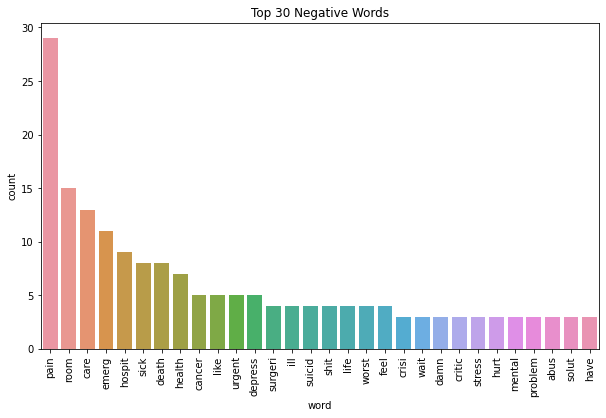

In [40]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='word', y='count', 
            data=top30_negative, ax=ax)
plt.title("Top 30 Negative Words")
plt.xticks(rotation='vertical');

#### **Neutral**

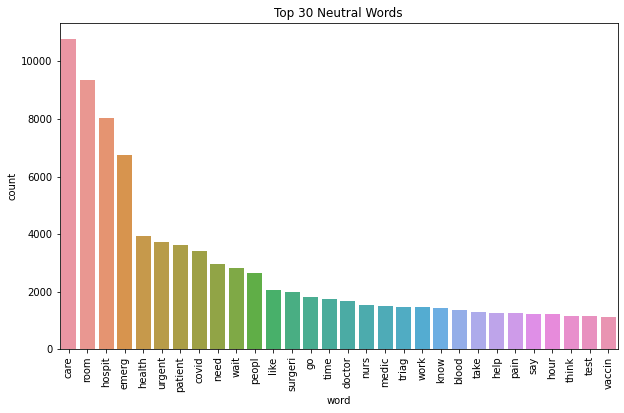

In [41]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='word', y='count', 
            data=top30_neutral, ax=ax)
plt.title("Top 30 Neutral Words")
plt.xticks(rotation='vertical');

In [42]:
filename='/content/drive/MyDrive/Omdena/Hyderabad Chapter - Chatbot for Admitted patients/Sentiment_analysis.csv'
data_sen.to_csv(filename, index = False, encoding='utf-8')